In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from saturation.utils import *

In [3]:
n_cores = 28

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "30g")
    .config("spark.driver.maxResultSize", "8g")
    .getOrCreate()
)

25/03/03 18:31:06 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/03/03 18:31:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/03 18:31:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/03 18:31:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Configuration

In [74]:
BASE_PATH = "/data/saturation/thesis_run_20250223/"
NSTATS = [
    int(0.5e6),
    int(1.0e6),
    int(1.5e6),
    int(2.0e6),
    int(2.5e6)
]
DPI = 400
FONT_SIZE = 24

# Load configurations

In [75]:
configs_df = read_configs_pandas(base_path=BASE_PATH)
configs_dict = configs_df.set_index("simulation_id").to_dict(orient="index")

In [76]:
simulation_id = 10
configs_df[configs_df.simulation_id == simulation_id]

,calculate_areal_density,calculate_nearest_neighbor_stats,initial_rim_calculation_method,mrp,random_seed,rim_erasure_method,rmax,rmin,rmult,rstat,...,spatial_hash_cell_size,stop_condition,study_region_padding,study_region_size,write_crater_removals_cadence,write_craters_cadence,write_image_cadence,write_image_points,write_state_cadence,write_statistics_cadence
144,True,True,{'name': 'circumference'},0.5,2109339755,"{'exponent': 1.0, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000


In [77]:
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

In [82]:
stats_df = spark.read.parquet(f"{BASE_PATH}/{simulation_id}/statistics_*.parquet")
craters_df = spark.read.parquet( f"{BASE_PATH}/{simulation_id}/craters_*.parquet")
removals_df = spark.read.parquet(f"{BASE_PATH}/{simulation_id}/crater_removals_*.parquet")

states = get_states(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    nstats=NSTATS,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark,
    result_columns=["crater_id", "radius", "nstat"],
    max_radius=15
)
states.set_index("nstat", inplace=True)

In [83]:
radii_by_nstat = {
    x: states.loc[x].radius.sort_values()
    for x in states.index
}

In [84]:
mle_slope, sigma = estimate_cumulative_slope(
    radii=states.loc[max(NSTATS)].radius,
    rmin=configs_dict[simulation_id]["rstat"],
    rmax=configs_dict[simulation_id]["rmax"],
    min_search_slope=-10.0,
    max_search_slope=-1
)

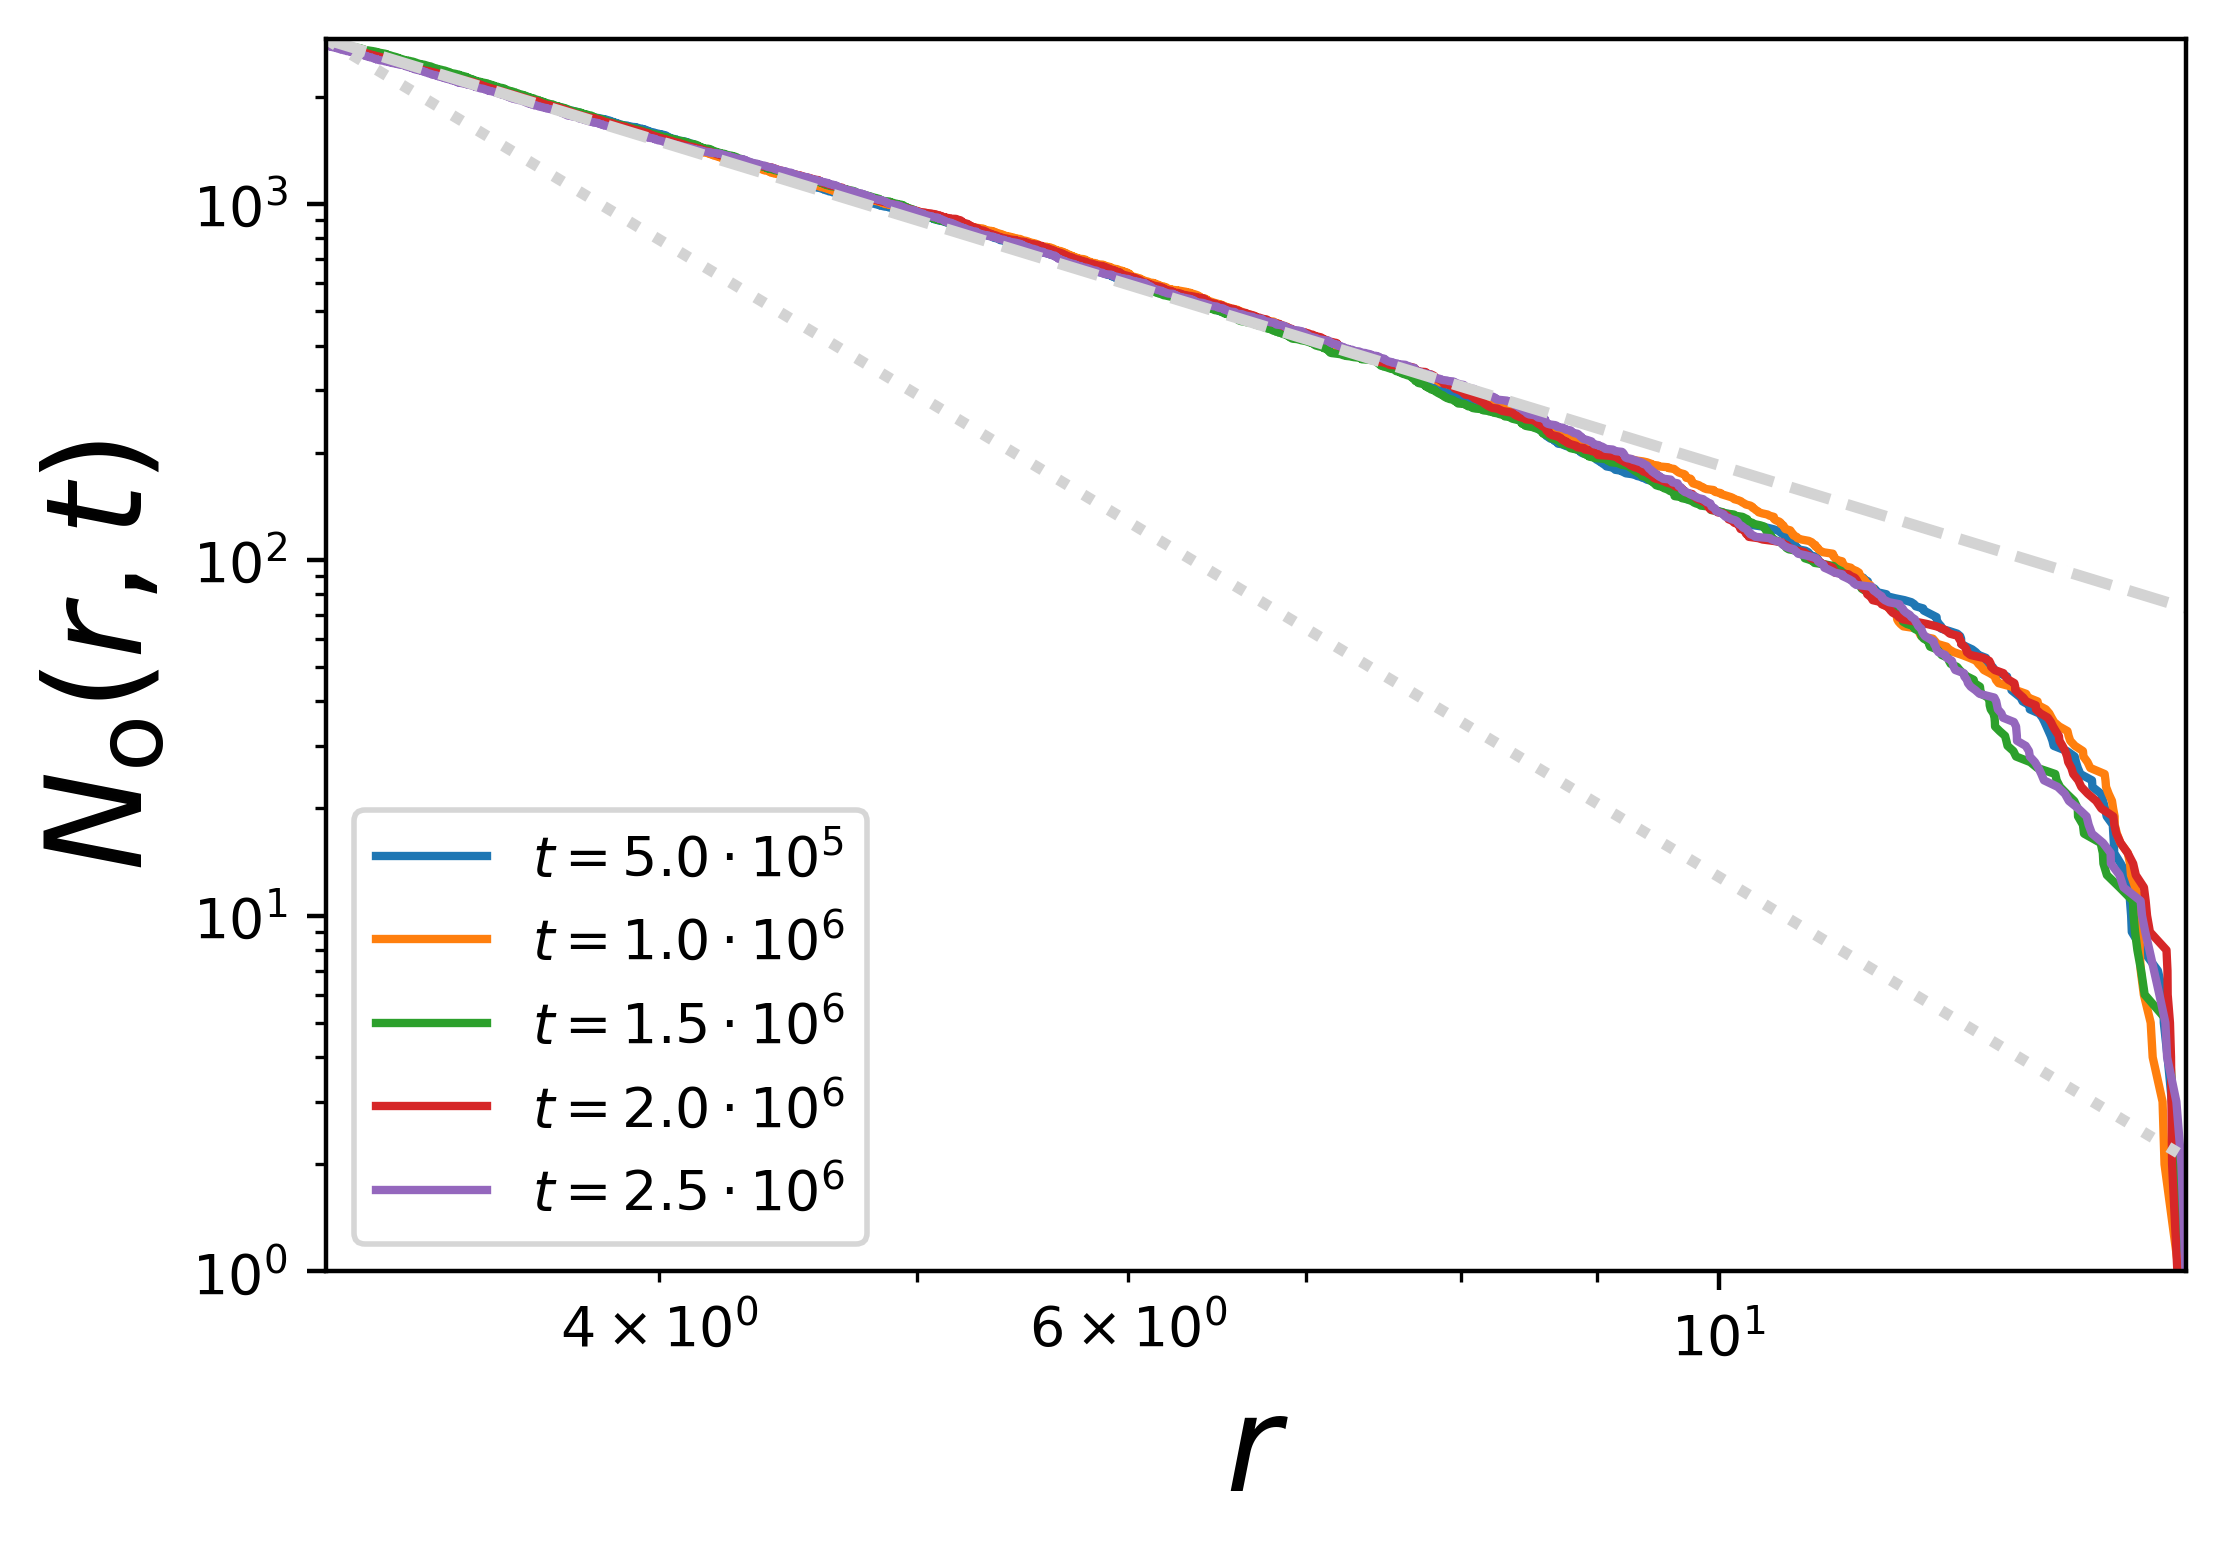

In [85]:
all_radii = states.radius.sort_values()
max_nobs = max(x.shape[0] for x in radii_by_nstat.values())
min_r_ref = all_radii.min()
b_p = configs_dict[simulation_id]["slope"]

fig = plt.figure(figsize=(6, 4), dpi=DPI)
ax = fig.add_subplot(111)

for nstat in NSTATS:
    radii = radii_by_nstat[nstat]
    nobs = range(len(radii), 0, -1)
    ax.plot(radii, nobs, label=f"$t={get_scientific_notation(nstat, 1)}$")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(all_radii.min()), np.log10(all_radii.max()), 100)

reference_lines = {
    b_p: {
        "intercepts": [max_nobs / min_r_ref ** b_p],
        "style": "dotted"
    },
    mle_slope: {
        "intercepts": [max_nobs / min_r_ref ** mle_slope],
        "style": "dashed"
    }
}

for b_ref, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**b_ref
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(all_radii.min(), all_radii.max())
ax.set_ylim(1, max_nobs)

# Labels and scaling
ax.set_xlabel("$r$", fontsize=FONT_SIZE)
ax.set_ylabel(r"$N_{\text{o}}(r, t)$", fontsize=FONT_SIZE)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/steep_sloped_sfd_saturation.png", bbox_inches="tight")

plt.show()